### Extract individual spectra from NASA exoplanet archive

In [198]:
import numpy as np
import pandas as pd
from scipy import stats
import pprint
import warnings
from pandas.errors import ParserWarning
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

import re
from pathlib import Path
import warnings
from typing import List, Dict, Tuple, Any, Union, Callable
from astropy.table import Table, MaskedColumn

from astroquery import mast
from astroquery.mast import Observations
from astropy.time import Time, TimeJD, TimeDelta
from astroquery.mast.missions import MastMissions
hst_mission = MastMissions(mission='hst')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 300

from tqdm import tqdm

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# local setup
WDIR = Path().cwd().parent

EMISSION_DATABASE_PATH = WDIR / "data/emissionspec.csv"
TRANSMISSION_DATABASE_PATH = WDIR / "data/transitspec.csv"

In [3]:
# date in converters
jd_converter = lambda bjd_time:Time(bjd_time, format="jd")

In [4]:
# load data of all planets with transmission or emission data from exoplanet archive

df_emission = pd.read_csv(EMISSION_DATABASE_PATH, header=18, index_col=0)

df_transmission = pd.read_csv(TRANSMISSION_DATABASE_PATH,
                              header=26, index_col=0,
                              # converters={
                              #     "plntranmid": jd_converter,
                              # },
                              dtype={
                                  "plntranmid": str,
                              }
                              )

plntranmid = df_transmission["plntranmid"].dropna(axis="index")

plntranmid_jd_time = pd.DataFrame(data=Time(plntranmid.to_numpy().astype(float),
                                            format="jd"),
                                  index=plntranmid.index,
                                  columns=["plntranmid_jd_time"])
plntranmid_jd_time["plntranmid_mjd_time"] = [t.mjd for t in plntranmid_jd_time["plntranmid_jd_time"]]

df_transmission = df_transmission.join(plntranmid_jd_time, how="left")

In [5]:
obs_table = Observations.query_criteria(dataproduct_type="SPECTRUM",
                                        proposal_id=12473,
                                        proposal_pi="Sing*",
                                        intentType="science",
                                        # instrument_name=None,
                                        # target_name=None,
                                        # t_max=None,
                                        # t_min=None,
                                        )


print(obs_table)
# print(obs_table.info)
print(obs_table.colnames)

data_products_by_obs = Observations.get_product_list(obs_table[0:2])

print(data_products_by_obs)
print(data_products_by_obs.colnames)

dataproduct_type calib_level obs_collection ... intentType  obsid     objID  
---------------- ----------- -------------- ... ---------- -------- ---------
        spectrum           3            HST ...    science 26100738 139158454
        spectrum           3            HST ...    science 26100778 139201157
        spectrum           3            HST ...    science 24964667 153323622
        spectrum           3            HST ...    science 24964679 153323633
        spectrum           3            HST ...    science 24964645 153325026
        spectrum           3            HST ...    science 24964655 153325169
        spectrum           3            HST ...    science 24964621 153325334
        spectrum           3            HST ...    science 24964633 153325662
        spectrum           3            HST ...    science 24964599 153325909
        spectrum           3            HST ...    science 24964609 153326353
             ...         ...            ... ...        ...      

In [6]:
print(df_transmission.columns)
print()
print(df_emission.columns)

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    column_mapping = {
        'plntname': 'Planet Name',
        'centralwavelng': 'Central Wavelength [microns]',
        'bandwidth': 'Band Width [microns]',
        'plntransdep': 'Transit Depth [percentage]',
        'plntransdeperr1': 'Transit Depth Upper Unc. [percentage]',
        'plntransdeperr2': 'Transit Depth Lower Unc. [percentage]',
        'plntransdeplim': 'Transit Depth Limit Flag',
        'plnradj': 'Planet Radius [Jupiter radii]',
        'plnradjerr1': 'Planet Radius Upper Unc. [Jupiter radii]',
        'plnradjerr2': 'Planet Radius Lower Unc. [Jupiter radii]',
        'plnradjlim': 'Planet Radius Limit Flag',
        'plnratror': 'Ratio of Planet to Stellar Radius',
        'plnratrorerr1': 'Ratio of Planet to Stellar Radius Upper Unc.',
        'plnratrorerr2': 'Ratio of Planet to Stellar Radius Lower Unc.',
        'plnratrorlim': 'Ratio of Planet to Stellar Radius Limit Flag',
        'plntranmid': 'Transit Mid-Point [BJD]',
        'plntranmiderr1': 'Transit Mid-Point Upper Unc. [BJD]',
        'plntranmiderr2': 'Transit Mid-Point Lower Unc. [BJD]',
        'plntranmidlim': 'Transit Mid-Point Limit Flag',
        'plntranreflink': 'Reference',
        'facility': 'Facility',
        'instrument': 'Instrument'
    }

    # Rename the columns using the column_mapping
    renamed_df = df.rename(columns=column_mapping)

    return renamed_df

Index(['plntname', 'centralwavelng', 'bandwidth', 'plntransdep', 'plntransdeperr1', 'plntransdeperr2', 'plntransdeplim', 'plnradj', 'plnradjerr1', 'plnradjerr2', 'plnradjlim', 'plnratror', 'plnratrorerr1', 'plnratrorerr2', 'plnratrorlim', 'plntranmid', 'plntranmiderr1', 'plntranmiderr2', 'plntranmidlim', 'plntranreflink', 'facility', 'instrument', 'plntranmid_jd_time', 'plntranmid_mjd_time'], dtype='object')

Index(['plntname', 'centralwavelng', 'bandwidth', 'especlipdep', 'especlipdeperr1', 'especlipdeperr2', 'especlipdeplim', 'espbritemp', 'espbritemperr1', 'espbritemperr2', 'espbritemplim', 'plntreflink', 'facility', 'instrument'], dtype='object')


In [7]:
def add_source_key(data_dict: Dict) -> Dict:
    # Extract the plntranreflink value
    reflink = data_dict.get('reflink', '')

    # Search for the 'authoryear' pattern using a regular expression
    pattern = re.compile(r'>(.+? et al\. \d{4})</a>|>(.+? \d{4})</a>')
    match = pattern.search(reflink)

    author_pattern = re.compile(r'\+\d{4}$')
    year_pattern = re.compile(r'\d{4}')

    if match:
        authoryear = match.group(1) if match.group(1) else match.group(2)
        if 'et al.' in authoryear:
            authoryear = authoryear.replace(' et al. ', '+')

        # Add the 'source' key with the extracted authoryear value
        data_dict['source'] = authoryear.strip()
        data_dict['author'] = re.sub(author_pattern, '',  data_dict['source'])
        year_match = re.search(year_pattern, data_dict['source'])
        data_dict['year'] = int(year_match.group(0)) if match else None
    else:
        data_dict['source'] = None
        data_dict['author'] = None
        data_dict['year'] = None

    return data_dict

def extract_data(df: pd.DataFrame) -> List[Dict]:
    # Group the DataFrame by unique combinations of planet_name, instrument, facility, and reflink
    grouped = df.groupby(['plntname', 'facility', 'instrument', 'plntranreflink'])

    result = []

    for (planet_name, facility, instrument, reflink), group in grouped:
        # Convert each group to a dictionary
        entry = {
            'planet_name': planet_name,
            'facility': facility,
            'instrument': instrument,
            'reflink': reflink,
            'data': group
        }

        # Add the entry to the result list

        entry = add_source_key(entry)

        result.append(entry)

    return result

split_transmission = extract_data(df_transmission)
# print(split_transmission[0])
print(split_transmission[0])

print(len(split_transmission))

{'planet_name': '55 Cnc e', 'facility': 'Hubble Space Telescope satellite', 'instrument': 'Wide Field Camera 3', 'reflink': '<a refstr=TSIARAS_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016ApJ...820...99T/abstract target=ref>Tsiaras et al. 2016</a>', 'data':        plntname  centralwavelng  bandwidth  plntransdep  ...                          facility           instrument  plntranmid_jd_time  plntranmid_mjd_time
rowid                                                    ...                                                                                                
1639   55 Cnc e          1.1320     0.0174       0.0358  ...  Hubble Space Telescope satellite  Wide Field Camera 3                 NaN                  NaN
1640   55 Cnc e          1.1495     0.0177       0.0361  ...  Hubble Space Telescope satellite  Wide Field Camera 3                 NaN                  NaN
1641   55 Cnc e          1.1674     0.0180       0.0337  ...  Hubble Space Telescope satellite  Wide Fie

In [8]:
TRANSMISSION_SPECTRA_PATH = WDIR / "data/transmission"
exts = [".txt"]

def get_txt_spectra_files_in_path(path, ):
    paths = list([
        p for p in Path(path).glob('*') if (p.suffix in exts and p.is_file())
    ])
    return paths

def read_headers(file_paths: List[str]) -> List[Dict]:
    headers = []

    for file_path in file_paths:
        # Read the header lines from the file
        with open(file_path, 'r') as file:
            header_lines = [line.strip() for line in file.readlines() if line.startswith('#')]

        # Create a dictionary with the header lines and filename
        header_dict = {
            'header': header_lines,
            'filename': file_path.name,
            'path': file_path
        }

        # Append the dictionary to the headers list
        headers.append(header_dict)

    return headers

transmission_spectra_files = get_txt_spectra_files_in_path(TRANSMISSION_SPECTRA_PATH)
test = transmission_spectra_files[0:5]
print(test)

transmission_spectra_files_info = read_headers(test)

print(transmission_spectra_files_info)


[WindowsPath('C:/Users/lukas/Documents/Git/compla/data/transmission/GJ1214b_transmission_Bean2011.txt'), WindowsPath('C:/Users/lukas/Documents/Git/compla/data/transmission/GJ1214b_transmission_Berta2012.txt'), WindowsPath('C:/Users/lukas/Documents/Git/compla/data/transmission/GJ1214b_transmission_Kreidberg2014.txt'), WindowsPath('C:/Users/lukas/Documents/Git/compla/data/transmission/GJ3470b_transmission_Benneke2019.txt'), WindowsPath('C:/Users/lukas/Documents/Git/compla/data/transmission/GJ436b_transmission_Knutson2014.txt')]
[{'header': ['# GJ1214b transmission spectrum', '# This file contains:', '# VLT FORS blue - Table 3 - Bean et al. 2011, ApJ, 743', '# VLT FORS red - Table 4 - Bean et al., 2011, ApJ, 743', '#', '# Analysis details:', '# values in this analysis were taken from Bean et al., 2010, Nature, 468', '# Period = 1.58040481 Â± 1.2E-7d days', '# Inclination = 88.94 degrees', '# a/R* = 14.9749', '#', '# Data history:', '# Converted by H.R. Wakeford from: Bean et al. (2011) in

In [9]:
def get_unique_planet_names(df: pd.DataFrame) -> List[str]:
    unique_planet_names = df['plntname'].unique().tolist()
    return unique_planet_names

# all_planets = get_unique_planet_names(df_transmission)

def unique_planets_and_counts(dict_list: List[Dict]) -> (List[str], List[float]):
    planet_counts = {}

    for item in dict_list:
        planet_name = item['planet_name']
        if planet_name in planet_counts:
            planet_counts[planet_name] += 1
        else:
            planet_counts[planet_name] = 1

    unique_planet_names = list(planet_counts.keys())
    counts = list(planet_counts.values())

    return unique_planet_names, counts

# TODO: write regex that checks for number of star systems: all non-special characters must be equal except for the letter at the last position.

all_planets, counts =unique_planets_and_counts(split_transmission)

print(f"Number of unique planets with transmission spectra: {len(all_planets)}.\n"
      f"\tMedian count: {np.median(counts)}, mean count: {np.median(counts):.1f} +/- {np.std(counts):.1f}, max count: {np.max(counts)} ({all_planets[np.argmax(counts)]}).")


Number of unique planets with transmission spectra: 103.
	Median count: 2.0, mean count: 2.0 +/- 3.8, max count: 21 (GJ 1214 b).


C:\Users\lukas\AppData\Local\Temp\ipykernel_9060\512398153.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(name_list))
C:\Users\lukas\anaconda3\envs\compla\lib\site-packages\matplotlib\axes\_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\lukas\anaconda3\envs\compla\lib\site-packages\matplotlib\axes\_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\lukas\anaconda3\envs\compla\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\lukas\anaconda3\envs\compla\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..

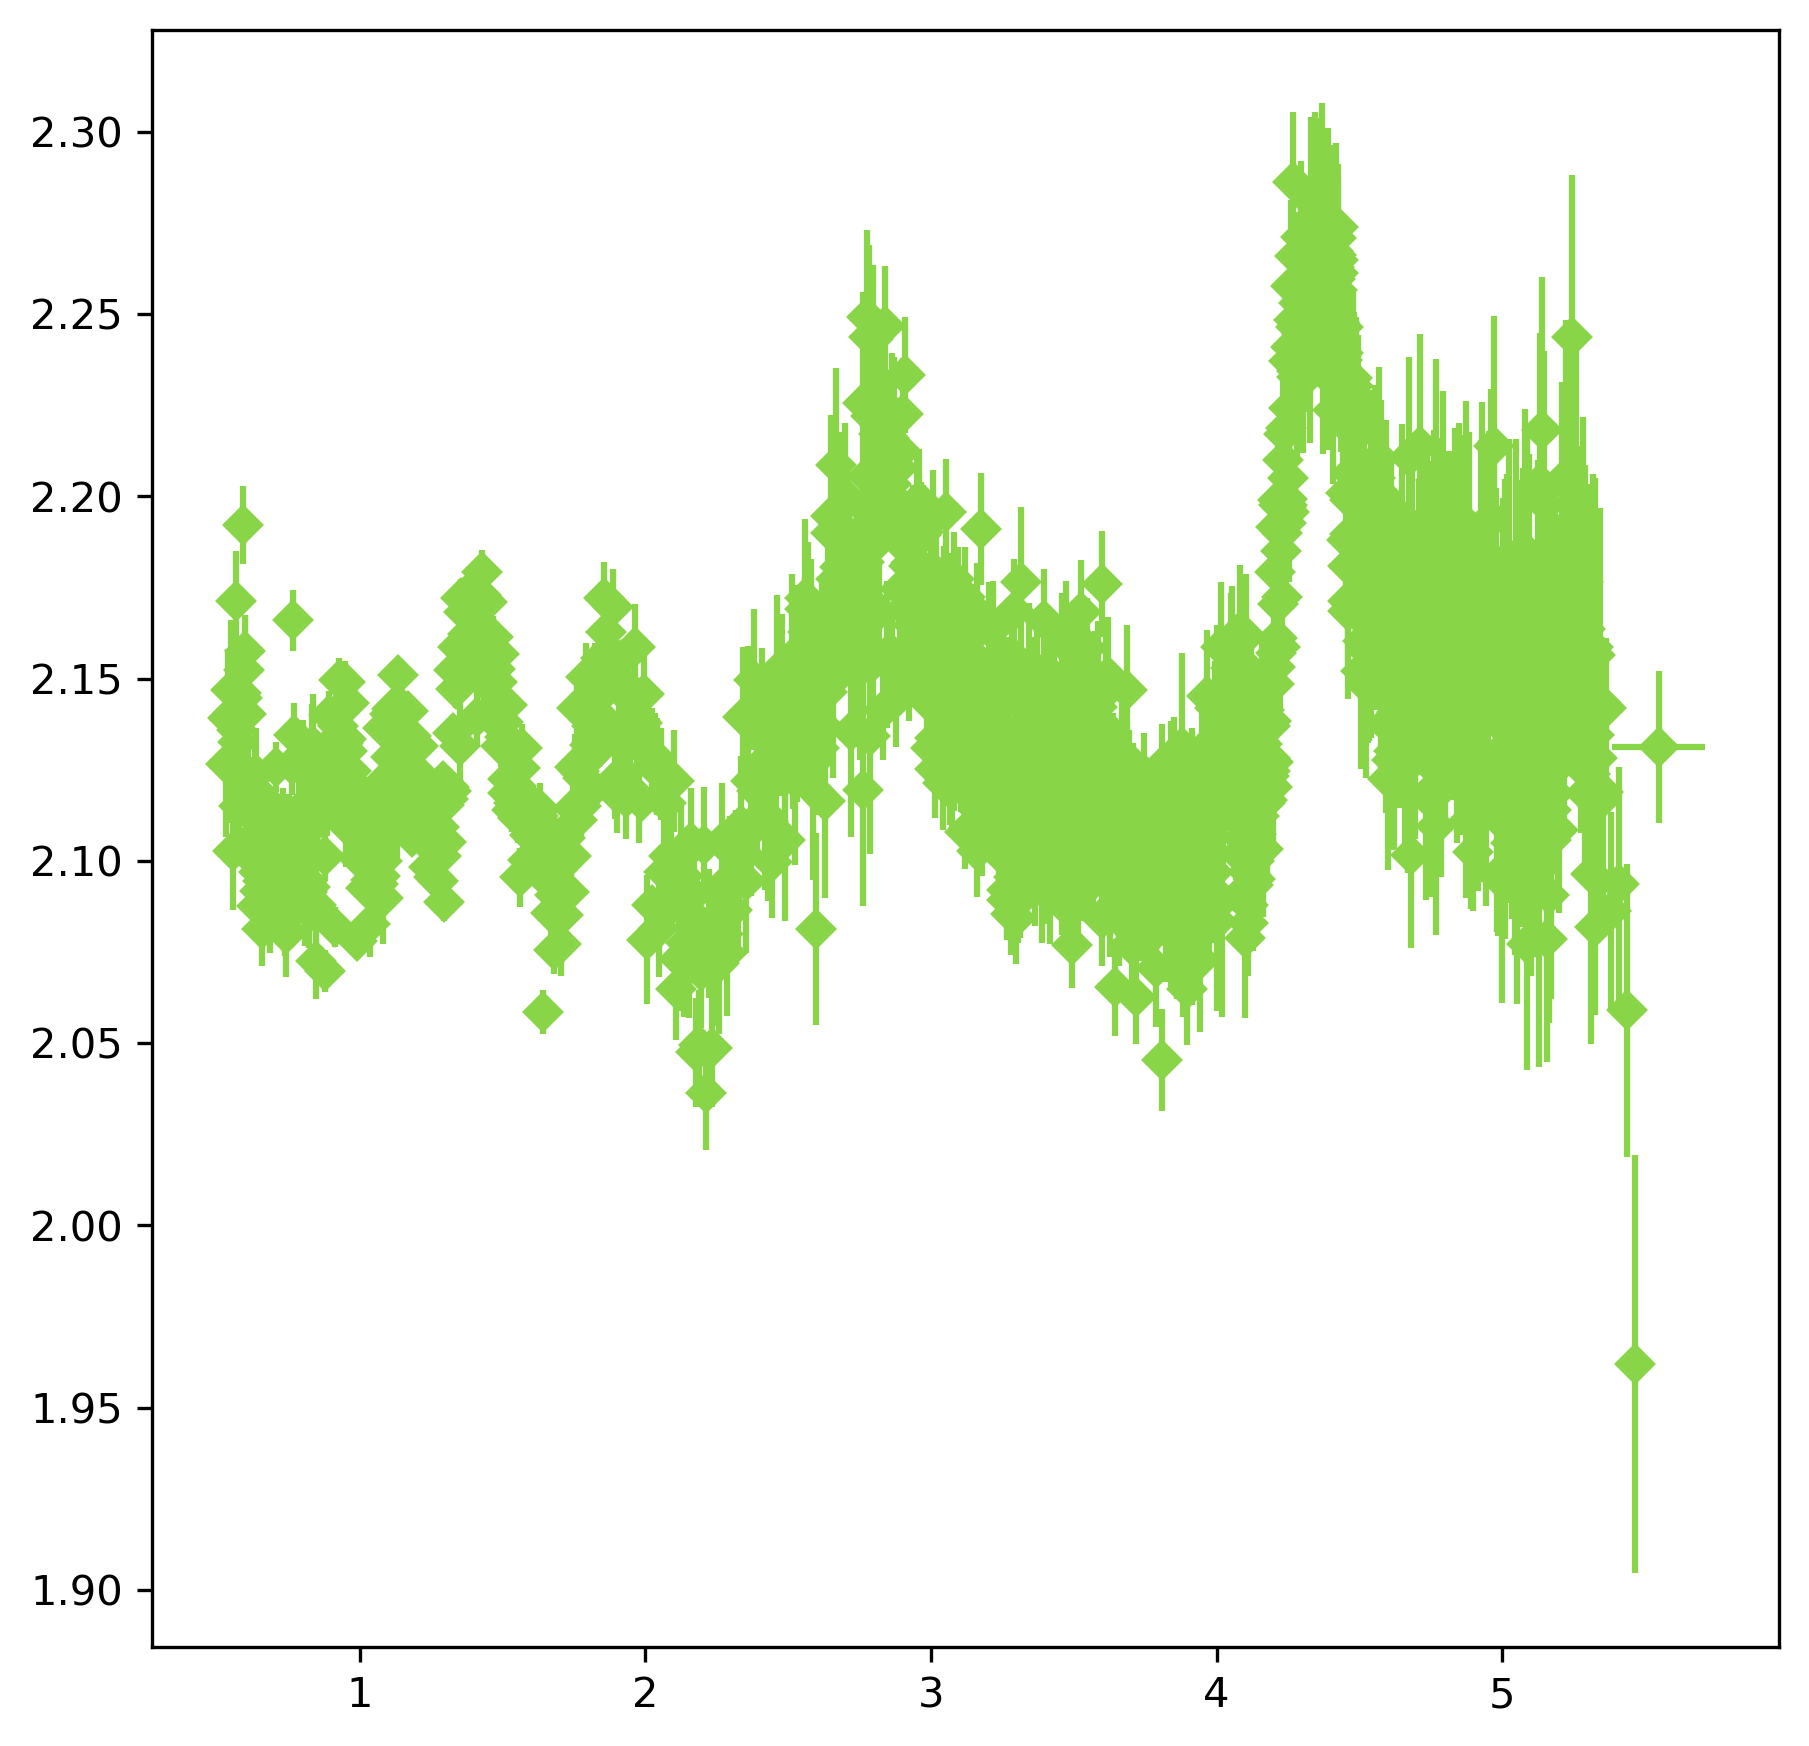

In [10]:
def get_color_for_name(name, name_list=all_planets):
    """
    Returns a unique Matplotlib color from the Viridis palette for the given name string.

    Parameters:
    name (str): the name string for which to generate a unique color.
    name_list (list): a list of unique name strings.

    Returns:
    color (str): a unique Matplotlib color from the Viridis palette.
    """
    # Generate a colormap with the same number of colors as the number of unique names.
    cmap = plt.cm.get_cmap('viridis', len(name_list))
    # Get the index of the given name in the list of unique names.
    index = name_list.index(name)
    # Get the corresponding color from the colormap.
    color = cmap(index)
    return color

def add_spec_to_ax(ax, spec_dict, **kwargs):
    df = spec_dict["data"]
    color = get_color_for_name(spec_dict["planet_name"])

    try:
        # print(df[['centralwavelng', 'bandwidth', "plntransdep", 'plntransdeperr1', 'plntransdeperr2']])
        xerr = [0.5 * df['bandwidth'],
                0.5 * df['bandwidth']]
        ax.errorbar(data=df,
                    x="centralwavelng", y="plntransdep",
                    yerr=np.abs([df['plntransdeperr1'], df['plntransdeperr2']]),
                    xerr=xerr,
                    fmt='D', color=color)
    except ValueError:
        try:
            ax.scatter(data=df,
                x="centralwavelng", y="plntransdep",
                markers='D')
        except ValueError:
            pass


    # ax.scatter(data=df,
    #            x="centralwavelng", y="plntransdep",
    #            )
    pass

%matplotlib inline
fig, ax = plt.subplots()
# [print(_spec) for _spec in split_transmission[0:2]] # if _spec["plntname"] == "GJ 1214 b"]
for spec in [_spec for _spec in split_transmission if _spec["planet_name"] == "WASP-39 b"]:
    add_spec_to_ax(ax, spec)

plt.show()

In [11]:
def extract_paper_info_from_ref(input_str):
    input_str = input_str.split('href=http', 1)[-1]

    author_pattern = r"target=ref>\s*([\w]+)\s+et al\."
    year_pattern = r"et al\. (\d{4})"
    journal_pattern = r"abs\/(?:\d+)?([A-Za-z&%]+)\.?"
    journal_number_pattern = r"abs\/\d*[A-Za-z&%]+\.?(\S+?)\/"

    author_match = re.search(author_pattern, input_str)
    year_match = re.search(year_pattern, input_str)
    journal_match = re.search(journal_pattern, input_str)
    journal_number_match = re.search(journal_number_pattern, input_str)

    author = author_match.group(1) if author_match else ""
    year = year_match.group(1) if year_match else ""
    journal = journal_match.group(1) if journal_match else ""
    journal_number = journal_number_match.group(1) if journal_number_match else ""

    # Replace "%26" with "&" for A&A journal
    journal = journal.replace("%26", "&")

    result = {
        'author': author,
        'year': year,
        'journal': journal,
        'journal_number': journal_number,
        'full_reference': f"{author} {year} {journal} {journal_number}".strip()
    }

    return result

test_strs_ref = [
    "<a refstr=WAKEFORD_ET_AL__2013 href=https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.3481W/abstract target=ref> Wakeford et al. 2013</a>",
    "<a refstr=DRAGOMIR_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...814..102D/abstract target=ref>Dragomir et al. 2015</a>",
    "<a refstr=KIRK_ET_AL__2018 href=https://ui.adsabs.harvard.edu/abs/2018MNRAS.474..876K/abstract target=ref>Kirk et al. 2018</a>",
    "<a refstr=SWAIN_ET_AL__2021 href=https://ui.adsabs.harvard.edu/abs/2021arXiv210305657S/abstract target=ref>Swain et al. 2021</a>",
    "<a refstr=FU_ET_AL__2022 href=https://ui.adsabs.harvard.edu/abs/2022arXiv221113761F/abstract target=ref>Fu et al. 2022</a>",
]

test_out = [extract_paper_info_from_ref(t) for t in test_strs_ref]

print(test_out)

[{'author': 'Wakeford', 'year': '2013', 'journal': 'MNRAS', 'journal_number': '435.3481W', 'full_reference': 'Wakeford 2013 MNRAS 435.3481W'}, {'author': 'Dragomir', 'year': '2015', 'journal': 'ApJ', 'journal_number': '..814..102D', 'full_reference': 'Dragomir 2015 ApJ ..814..102D'}, {'author': 'Kirk', 'year': '2018', 'journal': 'MNRAS', 'journal_number': '474..876K', 'full_reference': 'Kirk 2018 MNRAS 474..876K'}, {'author': 'Swain', 'year': '2021', 'journal': 'arXiv', 'journal_number': '210305657S', 'full_reference': 'Swain 2021 arXiv 210305657S'}, {'author': 'Fu', 'year': '2022', 'journal': 'arXiv', 'journal_number': '221113761F', 'full_reference': 'Fu 2022 arXiv 221113761F'}]


In [12]:
def extract_paper_info_from_header(text):
    if "et al." not in text:
        return False

    author_pattern = r"([A-Za-z\.\s]+?)et al\."
    year_pattern = r"(\d{4})"
    journal_pattern = r"(ApJ|ApJL|Nature|Natur|Science|arXiv|MNRAS|AJ|A&A|A%26A)(?:(?:\s*,)|(?=\d{4}))"
    journal_number_pattern = r"(?:,\s*)(\S*?)(?:\s*-)"

    author = re.search(author_pattern, text)
    year = re.search(year_pattern, text)
    journal = re.search(journal_pattern, text)
    journal_number = re.search(journal_number_pattern, text)

    author = author.group(1) if author else ""
    year = year.group(1) if year else ""
    journal = journal.group(1) if journal else ""
    journal_number = journal_number.group(1) if journal_number else ""

    full_reference = f"{author} {year} {journal} {journal_number}".strip()

    return {
        'author': author.strip() ,
        'year': year,
        'journal': journal,
        'journal_number': journal_number,
        'full_reference': full_reference
    }


# TODO: still not good, author_pattern does not match author, author not detected sometimes


#  difficult to parse, large diversity, maybe instead break down into multiple parsers?
# inconsistencies: et al., commas, multiple authors+ et al.???
#

# def extract_paper_info_from_header(text):
#     if "et al." not in text:
#         return False
#
#     author_pattern = r"([\w\s]+(?:\s+de|\s+van)?[\w\s]+?)(?:,|,)et al\."
#     year_pattern = r"(198\d|199\d|200\d|201\d|202[0-3])"
#     journal_pattern = r"(ApJ|ApJL|Nature|Natur|Science|arXiv|MNRAS|AJ|A&A|A%26A)(?:(?:\s*,)|(?=\d{4}))"
#     journal_number_pattern = r"(?:,\s*)(\S*?)(?:\s*-)"
#     go_pattern = r"GO \d{5}"
#
#     text = re.sub(go_pattern, "", text)
#
#     author = re.search(author_pattern, text)
#     year = re.search(year_pattern, text)
#     journal = re.search(journal_pattern, text)
#     journal_number = re.search(journal_number_pattern, text)
#
#     author = author.group(1).strip() if author else ""
#     year = year.group(1) if year else ""
#     journal = journal.group(1) if journal else ""
#     journal_number = journal_number.group(1) if journal_number else ""
#
#     if not author:
#         return False
#
#     full_reference = f"{author} {year} {journal} {journal_number}".strip()
#
#     return {
#         'author': author,
#         'year': year,
#         'journal': journal,
#         'journal_number': journal_number,
#         'full_reference': full_reference
#     }

test_strs_header = [
    "# VLT FORS blue - Table 3 - Bean et al. 2011, ApJ, 743",
    "# values in this analysis were taken from Bean et al., 2010, Nature, 468",
    "# WFC3 G141 - GO 13021 - Kreidberg, et al., 2014, Nature - DOI:10.1038/nature12888",
    "# WFC3 G141 - GO 12251 - Berta, et al., 2012, ApJ, 747, 1, 35",
    "# Berta et al. (2012) Table 2",
    "# WFC3 UVIS G280 - GO 15288 - Wakeford et al. 2020, AJ",
    "# WFC3 G141 - GO 14873 - de Wit, Wakeford, Lewis, et al. 2018, Nature Astronomy",
    "# Converted by H.R. Wakeford from: de Wit, Wakeford, Lewis, et al. 2018, Nature Astronomy",
    "# STIS G430L - GO 12473 - Sing et al. 2013, MNRAS",
    "# Re-presented in Sing et al. 2016, Nature",
    "# WFC3 G141 - GO 14468 - Evans et al. 2016, ApJL"
]

test_out = [extract_paper_info_from_header(t) for t in test_strs_header]

print(test_out)


[{'author': 'Bean', 'year': '2011', 'journal': 'ApJ', 'journal_number': '', 'full_reference': 'Bean  2011 ApJ'}, {'author': 'values in this analysis were taken from Bean', 'year': '2010', 'journal': 'Nature', 'journal_number': '', 'full_reference': 'values in this analysis were taken from Bean  2010 Nature'}, {'author': '', 'year': '1302', 'journal': '', 'journal_number': 'Nature', 'full_reference': '1302  Nature'}, {'author': '', 'year': '1225', 'journal': 'ApJ', 'journal_number': '', 'full_reference': '1225 ApJ'}, {'author': 'Berta', 'year': '2012', 'journal': '', 'journal_number': '', 'full_reference': 'Berta  2012'}, {'author': 'Wakeford', 'year': '1528', 'journal': '', 'journal_number': '', 'full_reference': 'Wakeford  1528'}, {'author': '', 'year': '1487', 'journal': '', 'journal_number': '', 'full_reference': '1487'}, {'author': '', 'year': '2018', 'journal': '', 'journal_number': '', 'full_reference': '2018'}, {'author': 'Sing', 'year': '1247', 'journal': '', 'journal_number': 

In [13]:
# get Sing et al. 2016 planets + spectra
sing_spectra = [spec for spec in split_transmission if (spec["source"] in ["Sing+2016", "Sing+2015"] and spec["instrument"] in ["Space Telescope Imaging Spectrograph", "Wide Field Camera 3"])]

# [print(spec["source"], spec["planet_name"], spec["instrument"]) for spec in sing_spectra];

obs_table = Observations.query_criteria(dataRights="public",
                                        intentType="science",
                                        instrument_name="WFC3/IR*",
                                        target_name="HAT-P-12",
                                        # t_max=None,
                                        # t_min=None,
                                        )



print(obs_table['target_name', 'instrument_name', "t_max", "t_min"])
# print(obs_table.info)
print(obs_table.colnames)

# data_products_by_obs = Observations.get_product_list(obs_table[0:10])


# print(data_products_by_obs['description', 'type'])
# print(data_products_by_obs.colnames)

# print()
#
# [print(spec["planet_name"], spec["instrument"], spec["source"]) for spec in split_transmission
#  if (spec["instrument"] in ["Space Telescope Imaging Spectrograph", "Wide Field Camera 3"]
#      and spec["planet_name"] in ["WASP-6 b", "WASP-19 b", "WASP-31 b"])];


target_name instrument_name     t_max          t_min     
----------- --------------- -------------- --------------
   HAT-P-12         WFC3/IR    57368.11931    57368.11801
   HAT-P-12         WFC3/IR    57368.26162    57368.26032
   HAT-P-12         WFC3/IR    57368.13153    57368.13023
   HAT-P-12         WFC3/IR    57368.37169    57368.37039
   HAT-P-12         WFC3/IR    57368.12949    57368.12819
   HAT-P-12         WFC3/IR    57368.17909    57368.17779
   HAT-P-12         WFC3/IR    57368.18723    57368.18594
   HAT-P-12         WFC3/IR    57368.13279    57368.13227
   HAT-P-12         WFC3/IR    57368.24532    57368.24403
   HAT-P-12         WFC3/IR    57368.39002    57368.38873
        ...             ...            ...            ...
   HAT-P-12         WFC3/IR 57631.73914634 57631.73784968
   HAT-P-12         WFC3/IR 57631.86751412 57631.86621783
   HAT-P-12         WFC3/IR 57631.67291931 57631.67162301
   HAT-P-12         WFC3/IR 57631.74499857 57631.74396079
   HAT-P-12   

In [18]:
columns = hst_mission.get_column_list()

print(list(columns))

[<Row index=0>
   name    data_type           description           
  str22       str9                str226             
---------- --------- --------------------------------
search_pos    string Search Position (RA and Dec)    , <Row index=1>
       name       data_type                                                                                                 description                                                                                                 
      str22          str9                                                                                                      str226                                                                                                   
----------------- --------- ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sci_data_set_name    string Data set name, the first ch

In [199]:
from copy import deepcopy
#
# print(split_transmission[236].keys())
# print(split_transmission[236]["data"].columns)
# print(split_transmission[236]["data"][["plntname", "centralwavelng", "bandwidth", "facility", "instrument", 'plntranmid_mjd_time']][:5])

# Wide Field Camera 3 HAT-P-1 b 28 56113.84530699998 58

# [print(s["instrument"], s["planet_name"], len(s["data"]), s["data"]['plntranmid_mjd_time'].iloc[0], i) for i, s in enumerate(split_transmission) if (s["instrument"] == "Wide Field Camera 3" and np.isfinite(s["data"]['plntranmid_mjd_time'].iloc[0]))]

def alias_instrument(s: str):
    alias_dict = {
        "Wide Field Camera 3": "WFC3",
        "Space Telescope Imaging Spectrograph": "STIS",
        # Add more aliases as necessary
    }
    if s in alias_dict:
        return alias_dict[s]
    else:
        return s

def get_count_elements(column: MaskedColumn):
    """Return the most frequent element in the given Astropy MaskedColumn."""
    if isinstance(column, MaskedColumn):
        column = column.filled(np.nan)

    mode, counts = stats.mode(column, nan_policy="omit")
    return mode.flatten(), counts.flatten()

def check_time_window(table: Table, value: float) -> (bool, np.ndarray):
    """Return an array indicating if the float is between two column values for each row."""
    col1, col2 = table[table.colnames[0]], table[table.colnames[1]]

    col1, col2 = Time(np.array(col1), format='isot', scale='utc'), Time(np.array(col2), format='isot', scale='utc')

    if value == np.nan:
        return False, []
    else:
        value = Time(value, format="mjd")
        delta1, delta2 = col1 - value, col2 - value
        return True, np.unique([np.argwhere(delta1.isclose(TimeDelta(0., format="sec"), atol=TimeDelta(600, format="sec"))), np.argwhere(delta2.isclose(TimeDelta(0., format="sec"), atol=TimeDelta(600, format="sec")))])

def check_wavelength_window(table: Table, value: float, scale: float) -> (bool, np.ndarray):
    """Return an array indicating if the float is between two column values for each row."""
    col1, col2 = table[table.colnames[0]], table[table.colnames[1]]

    col1, col2 = np.array(col1, dtype=float), np.array(col2, dtype=float)

    if value == np.nan:
        return False, []
    else:
        delta1, delta2 = np.abs(col1 - value * scale), np.abs(col2 - value * scale)
        return True, np.unique([delta1.argmin(), delta2.argmin()])

def check_central_wavelength(col: MaskedColumn, value: float, scale: float) -> (bool, np.ndarray):
    """Return an array indicating if the float is close to the column values for each row."""

    col = np.array(col, dtype=float)

    if value == np.nan:
        return False, []
    else:
        delta1 = np.abs(col - value * scale)
        return True, np.argwhere(np.isclose(delta1, 0., atol=10., rtol=0.)).flatten()

# def assign_spec_element_to_obs(obs, results, planet_name, instrument):
#     try:
#         time_match, t_window_crit = check_time_window(results["sci_start_time", "sci_stop_time"], obs["plntranmid_mjd_time"])
#         # wavelength_window_match, wavelng_window_crit = check_wavelength_window(results["sci_spectrum_start", "sci_spectrum_end"], obs.loc["centralwavelng"], scale=1e4)
#         # wavelength_match, central_wavelng_crit = check_central_wavelength(results["sci_central_wavelength"], obs.loc["centralwavelng"], scale=1e4)
#     except ValueError:
#         t_window_crit = np.arange(len(results))
#
#
#     if (np.all(results['sci_aper_1234'][t_window_crit] == results['sci_aper_1234'][t_window_crit][0])
#             and np.all(results['sci_spec_1234'][t_window_crit] == results['sci_spec_1234'][t_window_crit][0])):
#         return pd.Series({
#             'spectral_element': results['sci_spec_1234'][t_window_crit][0],
#             "aperture": results['sci_aper_1234'][t_window_crit][0],
#         })
#     else:
#         spec_mode, spec_count = get_most_frequent_element(results['sci_spec_1234'][t_window_crit])
#         aper_mode, aper_count = get_most_frequent_element(results['sci_aper_1234'][t_window_crit])
#
#         warnings.warn(f"Could not find matching spectral element and aperture for {planet_name} - {instrument}\n"
#                       f"Using spectral_element: {spec_mode[0]} ({spec_count[0] / np.sum(spec_count) * 100:.3f} % match)\n"
#                       f"Using aperture:         {aper_mode[0]} ({aper_count[0] / np.sum(aper_count) * 100:.3f} % match)")
#
#         return pd.Series({
#             'spectral_element': spec_mode[0],
#             "aperture": aper_mode[0],
#         })
#
# def get_mast_obs_data(spec):
#     planet_name = spec["planet_name"]
#     facility = spec["facility"]
#     instrument = spec['instrument']
#     data = spec["data"]
#     source = spec['source']
#     author = spec['author']
#     year = spec['year']
#
#     drop_keys = ["spectral_element", "aperture"]
#     for key in drop_keys:
#         try:
#             spec["data"].drop(key, axis="columns", inplace=True)
#         except KeyError:
#             pass
#
#     target_name = re.sub(r'[a-z]$', '', planet_name).strip() # +"*"
#     sci_targname=target_name + "*," + (target_name.replace(' ', '-'))
#     facility = alias_instrument(facility)+"*"
#     instrument = alias_instrument(instrument) +"*"
#
#     try:
#         results = hst_mission.query_criteria(
#             target=target_name,
#             sci_targname=sci_targname,
#             select_cols=[
#                 'sci_targname',
#                 'sci_instrume', 'sci_instrument_config', 'sci_aper_1234', 'sci_spec_1234',
#                 'sci_central_wavelength', 'sci_spectrum_end', 'sci_spectrum_start', 'sci_bandwidth', 'sci_spectral_res',
#                 'sci_preview_name', 'sci_refnum', 'sci_aec', 'sci_status', 'sci_data_set_name', 'sci_pi_last_name',
#                 'sci_actual_duration', 'sci_start_time', 'sci_stop_time',
#             ],
#             sci_instrume=instrument.lower(),
#             sci_obs_type='all',
#             sci_aec='S',
#         )
#
#         new = data.apply(assign_spec_element_to_obs, axis="columns", args=(results,
#                                                                            planet_name,
#                                                                            instrument),
#                          )
#
#         data = pd.concat([data, new], axis=1)
#
#
#         spec["data"] = data
#
#     except IndexError:
#         warnings.warn(f"No matches in {target_name} - {sci_targname} - {instrument.lower()}")
#         spec["data"]["spectral_element"] = "OUTER FAILURE"
#         spec["data"]["aperture"] = "OUTER FAILURE"
#
#     return spec

def assign_spec_element_to_obs(obs: pd.Series, results: pd.DataFrame, planet_name: str, instrument: str) -> pd.Series:
    """
    Assigns the spectral element and aperture to the given observation based on the given results.

    Parameters
    ----------
    obs : pd.Series
        A pandas Series containing the observation data.
    results : pd.DataFrame
        A pandas DataFrame containing the results data.
    planet_name : str
        The name of the planet for the observation.
    instrument : str
        The name of the instrument used for the observation.

    Returns
    -------
    pd.Series
        A pandas Series containing the assigned spectral element and aperture.

    Raises
    ------
    ValueError
        If a ValueError is encountered while processing the time windows.
    """

    # Check if the observation is within the time window criteria
    try:
        time_match, t_window_crit = check_time_window(results["sci_start_time", "sci_stop_time"], obs["plntranmid_mjd_time"])
    except ValueError:
        t_window_crit = np.arange(len(results))

    # Check if the aperture and spectral element are consistent
    if (np.all(results['sci_aper_1234'][t_window_crit] == results['sci_aper_1234'][t_window_crit][0])
            and np.all(results['sci_spec_1234'][t_window_crit] == results['sci_spec_1234'][t_window_crit][0])):
        return pd.Series({
            'spectral_element': results['sci_spec_1234'][t_window_crit][0],
            "aperture": results['sci_aper_1234'][t_window_crit][0],
        })
    else:
        # Get the most frequent spectral element and aperture
        spec_mode, spec_count = get_count_elements(results['sci_spec_1234'][t_window_crit])
        aper_mode, aper_count = get_count_elements(results['sci_aper_1234'][t_window_crit])

        if not (len(spec_mode)==1 and len(aper_mode)==1):
        # Issue a warning about the inconsistency
            warnings.warn(f"{planet_name} - {instrument}:\n"
                          f"Could not find matching spectral element and aperture."
                          f"Spectral_element: {spec_mode[0]} ({spec_count[0] / np.sum(spec_count) * 100:.3f} % match, total: {np.sum(spec_count[0])}/{np.sum(spec_count)})\n"
                          f"Aperture:         {aper_mode[0]} ({aper_count[0] / np.sum(aper_count) * 100:.3f} % match, total: {np.sum(aper_count[0])}/{np.sum(aper_count)})")

        # Return the most frequent spectral element and aperture
        return pd.Series({
            'spectral_element': spec_mode[0],
            "aperture": aper_mode[0],
        })

def get_mast_obs_data(spec: Dict[str, Any]) -> Dict[str, Any]:
    """
    Retrieves observation data from the MAST database for the given input specification and adds the data to the specification.

    Parameters
    ----------
    spec : Dict[str, Any]
        A dictionary containing the input specification including planet name, facility, instrument, data, source, author, and year.

    Returns
    -------
    Dict[str, Any]
        The input specification with the retrieved observation data added.

    Raises
    ------
    IndexError
        If no matches are found in the MAST database for the given target and instrument.
    """

    # Extract information from the input specification
    planet_name = spec["planet_name"]
    facility = spec["facility"]
    instrument = spec['instrument']
    data = spec["data"]
    source = spec['source']
    author = spec['author']
    year = spec['year']

    # Remove unnecessary keys from the data
    drop_keys = ["spectral_element", "aperture"]
    for key in drop_keys:
        try:
            spec["data"].drop(key, axis="columns", inplace=True)
        except KeyError:
            pass

    # Create target name and instrument aliases
    target_name = re.sub(r'[a-z]$', '', planet_name).strip()
    sci_targname = target_name + "*," + (target_name.replace(' ', '-'))
    facility = alias_instrument(facility) + "*"
    instrument = alias_instrument(instrument) + "*"

    # Query the MAST database for observation data
    try:
        results = hst_mission.query_criteria(
            target=target_name,
            sci_targname=sci_targname,
            select_cols=[
                'sci_targname',
                'sci_instrume', 'sci_instrument_config', 'sci_aper_1234', 'sci_spec_1234',
                'sci_central_wavelength', 'sci_spectrum_end', 'sci_spectrum_start', 'sci_bandwidth', 'sci_spectral_res',
                'sci_preview_name', 'sci_refnum', 'sci_aec', 'sci_status', 'sci_data_set_name', 'sci_pi_last_name',
                'sci_actual_duration', 'sci_start_time', 'sci_stop_time',
            ],
            sci_instrume=instrument.lower(),
            sci_obs_type='all',
            sci_aec='S',
        )

        # Assign spectral element and aperture to the retrieved data
        new = data.apply(assign_spec_element_to_obs, axis="columns", args=(results, planet_name, instrument))
        data = pd.concat([data, new], axis=1)

        spec["data"] = data

    # Handle cases where no matches are found
    except IndexError:
        warnings.warn(f"No matches in {target_name} - {sci_targname} - {instrument.lower()}")
        spec["data"]["spectral_element"] = "OUTER FAILURE"
        spec["data"]["aperture"] = "OUTER FAILURE"

    return spec

new_split_transmission = []


ins = ["Wide Field Camera 3", "Space Telescope Imaging Spectrograph"]

all_warnings = []
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore", category=DeprecationWarning, module='')
    warnings.filterwarnings("ignore", category=FutureWarning, module='')
    warnings.filterwarnings("ignore", category=RuntimeWarning, module='')
    warnings.filterwarnings("ignore", category=Warning, module='numpy')
    warnings.filterwarnings("ignore", category=Warning, module='scipy')
    warnings.filterwarnings("ignore", category=Warning, module='pandas')
    warnings.filterwarnings("ignore", category=Warning, module='astropy')
    warnings.filterwarnings("ignore", category=Warning, module='astroquery')

    for spec in tqdm([spec for spec in split_transmission if spec["instrument"] in ins]):
        new_split_transmission.append(get_mast_obs_data(spec))

    all_warnings.extend(w)


def_out_with_spectral_elements = pd.concat([spec["data"] for spec in new_split_transmission], axis=0)

def_out_with_spectral_elements.to_csv(WDIR / "data/transitspec_with_spectral_elements.csv")

100%|██████████| 61/61 [00:32<00:00,  1.90it/s]


In [200]:
if True:
    print("The following warnings were raised:")
    warns, idx, counts = np.unique([repr(w.message) for w in all_warnings], return_index=True, return_counts=True, )
    warns = np.array(all_warnings, dtype=object)[idx]

    for w, c in zip(warns, counts):
        message_str = re.sub(r'^.*?(Warning\()', r'\1', str(w.message).rsplit('Warning(', 1)[-1], count=1)
        print(f'Line: {w.lineno}, count: {c}: \n'
              f'{pprint.pformat(message_str)}')

The following warnings were raised:
Line: 273, count: 1: 
'No matches in GJ 1132 - GJ 1132*,GJ-1132 - wfc3*'
Line: 273, count: 1: 
'No matches in HAT-P-1 - HAT-P-1*,HAT-P-1 - wfc3*'
Line: 273, count: 1: 
'No matches in HD 189733 - HD 189733*,HD-189733 - stis*'
Line: 273, count: 1: 
'No matches in HD 189733 - HD 189733*,HD-189733 - wfc3*'
Line: 273, count: 1: 
'No matches in HD 209458 - HD 209458*,HD-209458 - wfc3*'
Line: 273, count: 2: 
'No matches in KELT-11 - KELT-11*,KELT-11 - wfc3*'
Line: 273, count: 1: 
'No matches in TRAPPIST-1 - TRAPPIST-1*,TRAPPIST-1 - wfc3*'
Line: 273, count: 1: 
'No matches in WASP-117 - WASP-117*,WASP-117 - wfc3*'
Line: 273, count: 2: 
'No matches in WASP-12 - WASP-12*,WASP-12 - stis*'
Line: 273, count: 1: 
'No matches in WASP-17 - WASP-17*,WASP-17 - wfc3*'
Line: 273, count: 1: 
'No matches in XO-1 - XO-1*,XO-1 - wfc3*'


In [15]:
# TODO: cross-correlate regex from NASA table and Wakeford archive table
# option1: in s1, s2,
# out similarity score, what norm? cant take s1/2 lengths due to difference length?
# similarity score -> regex for match (slide pattern)
# Take mean match score / max(lengths)

# option2: in dict1, dict2
# out, similarity score
# for each pair in dict, match part? -> regex match
# scale exp to reward high match %

In [16]:
# TODO: parse grisms/gratings
# regex match known HST WFC3, STIS grism/grating names
# take names from HST instrument handbook, table 4.2, 8.1 ?

"""
Write a function that takes a string as input and returns a bool and a diffractor_dict: Dict with keywords: instrument, diffractor, survey, author, year, journal.
The instrument is one of WFC, WFC3, STIS.
The diffrator is matches the pattern: the letters G or E, followed by three numbers, followed by nothing, L, M, LB, or MB. diffractor example: "G141".
The survey matches the pattern: "GO " followed by 5 letters. Survey example: "GO 12098".
the author is everything preceding et al. (et al. inclusive with or without dot) and after the previous match.
The journal is everything following the year, specifically one of (ApJ, Nature, Natur, Science, arXiv, MNRAS, AJ, A&A, A%26A, Nature Astronomy) and all following numbers and dots.

If no match for the instrument and diffractor: return False, {}
Else return True, diffractor_dict

Examples:
"# WFC3 G141 - GO 14873 - de Wit, Wakeford, Lewis, et al. 2018, Nature Astronomy" -> diffractor_dict = {"instrument": "WFC3", "diffractor": "G141", "survey": "GO 14873", "author": "de Wit, Wakeford, Lewis, et al.", "year": 2019, "journal": "Nature Astronomy"}

"# STIS G750L - GO 14767 - Evans et al., 2018, AJ 156" -> diffractor_dict = {"instrument": "STIS", "diffractor": "G750L", "survey": "GO 14767", "author": "Evans et al.", "year": 2018, "journal": "AJ 156"}

"""

'\nWrite a function that takes a string as input and returns a bool and a diffractor_dict: Dict with keywords: instrument, diffractor, survey, author, year, journal.\nThe instrument is one of WFC, WFC3, STIS.\nThe diffrator is matches the pattern: the letters G or E, followed by three numbers, followed by nothing, L, M, LB, or MB. diffractor example: "G141".\nThe survey matches the pattern: "GO " followed by 5 letters. Survey example: "GO 12098".\nthe author is everything preceding et al. (et al. inclusive with or without dot) and after the previous match.\nThe journal is everything following the year, specifically one of (ApJ, Nature, Natur, Science, arXiv, MNRAS, AJ, A&A, A%26A, Nature Astronomy) and all following numbers and dots.\n\nIf no match for the instrument and diffractor: return False, {}\nElse return True, diffractor_dict\n\nExamples:\n"# WFC3 G141 - GO 14873 - de Wit, Wakeford, Lewis, et al. 2018, Nature Astronomy" -> diffractor_dict = {"instrument": "WFC3", "diffractor": 

In [69]:
# TODO: low priority, parse grism/grating info from json

In [ ]:
# TODO: parse .txt files to get for each
# N: papers with parsed info, one for each line
# keep duplicates
# if found_grism_grating in line:
    # set matched_grism_grating_pattern to dict

In [ ]:
# TODO: asssign grisms/gratings:
# for each spectrum (differentiated) in List[df]
# match href citation with grism/prism papers -> ranking of similarity scores with grism (+paper)
# prelim assign grism to spectrum table

In [ ]:
# ideas if no matches, parse abstracts for grism/grating names? Really bad.
# where did I see grism/prism names in table??